# 전국 1인 가구 분포도 시각화

# 지하철 노선 포함 시각화

/Users/jeonhyewon/miniconda3/envs/py310/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/zq/2z3yxb292_3493bpkdxm8ywr0000gn/T/ipykernel_6955/1865799488.py:51: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = seoul_gu_gdf.unary_union
/var/folders/zq/2z3yxb292_3493bpkdxm8ywr0000gn/T/ipykernel_6955/1865799488.py:51: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = seoul_gu_gdf.unary_union


✅ 엑셀에서 추출된 자치구 개수: 25
  region   total
0    강남구   79274
1    강동구   65601
2    강북구   53705
3    강서구  106748
4    관악구  153605
✅ 안심귀갓길 마커(서울 내부) 개수: 347
✅ 서울 경계 내 역사(역) 개수: 286
✅ 호선 수: 9
✅ 호선 목록: ['1호선', '2호선', '3호선', '4호선', '5호선', '6호선', '7호선', '8호선', '9호선']


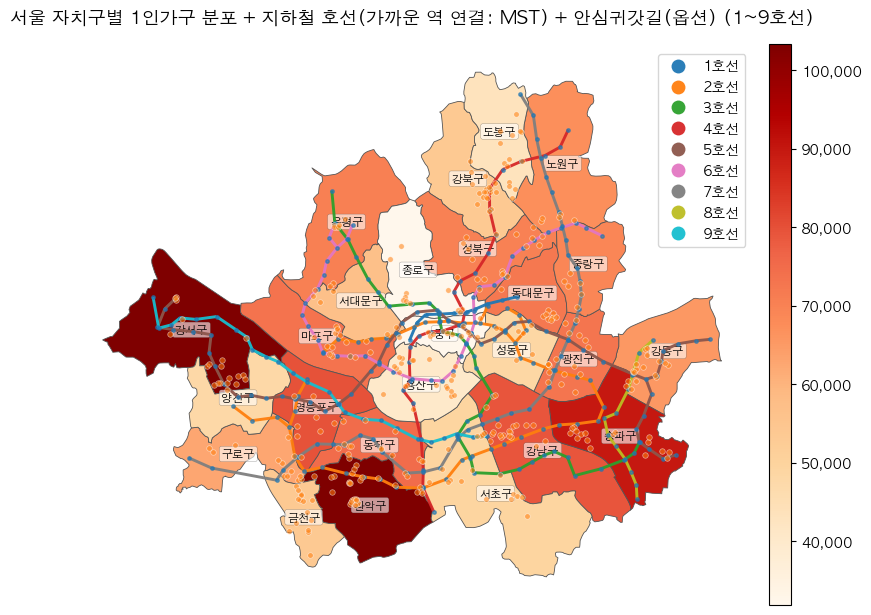

✅ 저장 완료: /Users/jeonhyewon/Desktop/스마트팩토리10기/6캔두잇/seoul_gu_single_households_with_subway_mst.png
ℹ️ 선이 '정확한 노선도'처럼 보이려면 (인접역/역순번) 또는 노선 polyline 데이터가 필요해요.


In [19]:
# -*- coding: utf-8 -*-
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import platform
from shapely.geometry import LineString

# =========================
# 파일 경로
# =========================
EXCEL_PATH = "1인가구_서울.xlsx"
GEOJSON_PATH = "hangjeongdong_서울특별시.geojson"

# ✅ 안심귀갓길(점)
SAFE_JSON_PATH = "서울시 안심귀갓길 서비스.json"

# ✅ 역사마스터(호선/역)
STATION_JSON_PATH = "서울시 역사마스터 정보.json"

OUT_PNG = "seoul_gu_single_households_with_subway_mst.png"

# =========================
# 옵션
# =========================
# 호선이 너무 많아서 복잡하면 1~9호선만 먼저 보기 추천
ONLY_1_TO_9 = True

# =========================
# 폰트 설정
# =========================
def set_korean_font():
    sys = platform.system()
    candidates = {
        "Darwin": ["AppleGothic"],
        "Windows": ["Malgun Gothic"],
        "Linux": ["NanumGothic", "Noto Sans CJK KR", "Noto Sans KR", "DejaVu Sans"],
    }.get(sys, ["DejaVu Sans"])
    plt.rcParams["font.family"] = candidates[0]
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# =========================
# 유틸: 서울 경계 안 점만 남기기(선/점이 외곽으로 튀는 걸 방지)
# =========================
def clip_points_to_seoul(points_gdf: gpd.GeoDataFrame, seoul_gu_gdf: gpd.GeoDataFrame):
    boundary = seoul_gu_gdf.unary_union
    return points_gdf[points_gdf.within(boundary)].copy()

# =========================
# 유틸: 역사마스터 JSON 로더(구조가 배열이 아닐 때도 대응)
# =========================
def load_station_master(path: str) -> pd.DataFrame:
    # 정상적인 JSON(list/dict)인 경우
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)

        if isinstance(data, list):
            return pd.DataFrame(data)

        if isinstance(data, dict):
            # {"DATA":[...]} 같은 구조
            for k in ["DATA", "data", "stations", "Station", "station"]:
                if k in data and isinstance(data[k], list):
                    return pd.DataFrame(data[k])

        raise ValueError("지원하지 않는 역사마스터 JSON 구조(리스트/DICT 내부 리스트가 아님)")

    except json.JSONDecodeError:
        # {".."}{".."}{".."} 이런 식으로 객체가 연달아 붙은 경우 대비
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()

        if txt.startswith("{") and txt.endswith("}"):
            txt = "[" + txt.replace("}\n{", "},{").replace("}{", "},{") + "]"
            data = json.loads(txt)
            return pd.DataFrame(data)

        raise

# =========================
# MST(최소 신장 트리)로 "가까운 역끼리만" 연결해서 선분 만들기
# - 장거리 점프(스파게티) 대폭 줄어듦
# - 순환선은 고리로 닫히진 않지만 보기엔 훨씬 자연스러움
# =========================
def build_route_edges_mst(g_station_route: gpd.GeoDataFrame):
    """
    입력: 한 호선(route)만 담긴 GeoDataFrame (projected CRS, meters)
    출력: 해당 호선의 MST 간선(LineString) 리스트
    """
    # scipy 필요
    try:
        from scipy.spatial.distance import pdist, squareform
        from scipy.sparse.csgraph import minimum_spanning_tree
    except ImportError as e:
        raise ImportError(
            "scipy가 필요합니다. `pip install scipy` 후 다시 실행하세요."
        ) from e

    grp = g_station_route.copy()
    if len(grp) < 2:
        return []

    xy = np.vstack([grp.geometry.x.values, grp.geometry.y.values]).T

    # 거리행렬 -> MST
    D = squareform(pdist(xy, metric="euclidean"))
    mst = minimum_spanning_tree(D).tocoo()

    edges = []
    for i, j in zip(mst.row, mst.col):
        p1 = grp.geometry.iloc[i]
        p2 = grp.geometry.iloc[j]
        edges.append(LineString([p1, p2]))
    return edges


# =========================
# 1) 엑셀 파싱: "구명", "값"만 사용
# =========================
raw = pd.read_excel(EXCEL_PATH, header=None)
raw = raw.iloc[:, :3].copy()
raw.columns = ["lvl1", "region", "value"]

raw["region"] = raw["region"].astype(str).str.strip()
gu = raw[raw["region"].str.endswith("구")].copy()

gu["total"] = (
    gu["value"].astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)
gu["total"] = pd.to_numeric(gu["total"], errors="coerce")
gu = gu.dropna(subset=["total"])
gu = gu[["region", "total"]].groupby("region", as_index=False)["total"].sum()

print("✅ 엑셀에서 추출된 자치구 개수:", len(gu))
print(gu.head())

# =========================
# 2) GeoJSON: 행정동 -> 자치구 dissolve
# =========================
g = gpd.read_file(GEOJSON_PATH)
if "sggnm" not in g.columns:
    raise ValueError(f"GeoJSON에 'sggnm'(자치구명) 컬럼이 없어요. 현재 컬럼: {list(g.columns)}")

g["sggnm"] = g["sggnm"].astype(str).str.strip()
g_gu = g.dissolve(by="sggnm", as_index=False)

# =========================
# 3) merge
# =========================
m = g_gu.merge(gu, left_on="sggnm", right_on="region", how="left")
missing = m[m["total"].isna()]["sggnm"].tolist()
if missing:
    print("⚠️ 매칭 실패 자치구(엑셀에 없는 구):", missing)

# =========================
# 4) CRS 변환(미터 단위): 라벨/거리/MST 안정적
# =========================
if m.crs is not None:
    m = m.to_crs(epsg=5179)

# =========================
# 5) 안심귀갓길(점) 로드 (옵션)
# =========================
safe_points = None
if os.path.exists(SAFE_JSON_PATH):
    with open(SAFE_JSON_PATH, "r", encoding="utf-8") as f:
        j = json.load(f)

    df_safe = pd.DataFrame(j.get("DATA", [])).copy()
    if not df_safe.empty and "longitude" in df_safe.columns and "latitude" in df_safe.columns:
        df_safe["longitude"] = pd.to_numeric(df_safe["longitude"], errors="coerce")
        df_safe["latitude"] = pd.to_numeric(df_safe["latitude"], errors="coerce")
        df_safe = df_safe.dropna(subset=["longitude", "latitude"])

        safe_points = gpd.GeoDataFrame(
            df_safe,
            geometry=gpd.points_from_xy(df_safe["longitude"], df_safe["latitude"]),
            crs="EPSG:4326"
        ).to_crs(m.crs)

        # 서울 경계 안만 남기기(옵션)
        safe_points = clip_points_to_seoul(safe_points, m)

        print("✅ 안심귀갓길 마커(서울 내부) 개수:", len(safe_points))

# =========================
# 6) 역사마스터(호선/역) 로드 -> 호선별 MST 간선 생성
# =========================
df_station = load_station_master(STATION_JSON_PATH)

# 필수 컬럼(네 데이터 기준)
need_cols = ["route", "lot", "lat", "bldn_nm"]  # route=호선, lot=경도, lat=위도, bldn_nm=역명
for c in need_cols:
    if c not in df_station.columns:
        raise ValueError(f"역사마스터에 '{c}' 컬럼이 없어요. 현재 컬럼: {list(df_station.columns)}")

df_station["route"] = df_station["route"].astype(str).str.strip()
df_station["lot"] = pd.to_numeric(df_station["lot"], errors="coerce")  # 경도
df_station["lat"] = pd.to_numeric(df_station["lat"], errors="coerce")  # 위도
df_station = df_station.dropna(subset=["route", "lot", "lat"])

g_station = gpd.GeoDataFrame(
    df_station,
    geometry=gpd.points_from_xy(df_station["lot"], df_station["lat"]),
    crs="EPSG:4326"
).to_crs(m.crs)

# 서울 경계 안 역만 남기기(중요)
g_station = clip_points_to_seoul(g_station, m)

# 호선 필터(복잡하면 1~9호선만)
if ONLY_1_TO_9:
    keep = [f"{i}호선" for i in range(1, 10)]
    g_station = g_station[g_station["route"].isin(keep)].copy()

print("✅ 서울 경계 내 역사(역) 개수:", len(g_station))
print("✅ 호선 수:", g_station["route"].nunique())
print("✅ 호선 목록:", sorted(g_station["route"].unique().tolist()))

# 호선별 MST 간선 만들기
line_records = []
for route, grp in g_station.groupby("route"):
    edges = build_route_edges_mst(grp)
    for e in edges:
        line_records.append({"route": route, "geometry": e})

g_lines = gpd.GeoDataFrame(line_records, crs=m.crs)

# =========================
# 7) 시각화 + 저장
# =========================
fig, ax = plt.subplots(figsize=(8.5, 10.5))

# (1) 자치구 Choropleth
vmin = m["total"].quantile(0.05)
vmax = m["total"].quantile(0.95)

m.plot(
    column="total",
    ax=ax,
    cmap="OrRd",
    legend=True,
    vmin=vmin,
    vmax=vmax,
    edgecolor="#555555",
    linewidth=0.6,
    missing_kwds={"color": "lightgrey", "label": "데이터 없음"},
    legend_kwds={"shrink": 0.55, "aspect": 25, "pad": 0.02},
)

# 컬러바 콤마
cax = ax.get_figure().axes[-1]
cax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# (2) 호선 "선분" (MST 간선) 그리기
# column="route"로 호선별 범례 자동 생성
g_lines.plot(
    ax=ax,
    linewidth=2.1,
    alpha=0.95,
    column="route",
    legend=True,
    zorder=8
)

# (3) 역 점도 같이 그리기(선이 어디로 이어지는지 확인용)
g_station.plot(
    ax=ax,
    markersize=6,
    alpha=0.65,
    zorder=9
)

# (4) 안심귀갓길 점(옵션)
if safe_points is not None:
    ax.scatter(
        safe_points.geometry.x,
        safe_points.geometry.y,
        s=16,
        alpha=0.55,
        edgecolor="white",
        linewidth=0.5,
        zorder=10,
    )

# (5) 자치구 라벨(투명도)
cent = m.geometry.centroid
m["cx"] = cent.x
m["cy"] = cent.y

for _, r in m.iterrows():
    if pd.isna(r["total"]):
        continue
    ax.text(
        r["cx"], r["cy"],
        r["sggnm"],
        ha="center", va="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#333333", lw=0.25, alpha=0.6),
        zorder=5
    )

title = "서울 자치구별 1인가구 분포 + 지하철 호선(가까운 역 연결: MST) + 안심귀갓길(옵션)"
if ONLY_1_TO_9:
    title += " (1~9호선)"
ax.set_title(title, fontsize=13)

ax.axis("off")
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight", pad_inches=0.25)
plt.show()

print("✅ 저장 완료:", os.path.abspath(OUT_PNG))
print("ℹ️ 선이 '정확한 노선도'처럼 보이려면 (인접역/역순번) 또는 노선 polyline 데이터가 필요해요.")
